<a href="https://colab.research.google.com/github/ArkAung/transformer_tutorial/blob/master/intuition_behind_word_embeddings_with_positional_information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation to get word2vec model

In [1]:
!pip install --upgrade gensim

In [2]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


For example, let's get the word vector for the word "dog", plot it to get visual understaning of the values at each dimension and get the 5 nearest neighbour words which are semantically similar to the word "dog"

# Inspecting on a single word vector

In [5]:
import matplotlib.pyplot as plt

In [6]:
dog_vector = wv["dog"]

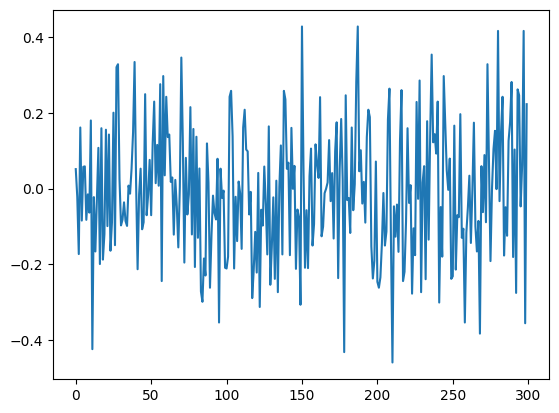

In [7]:
plt.plot(dog_vector)

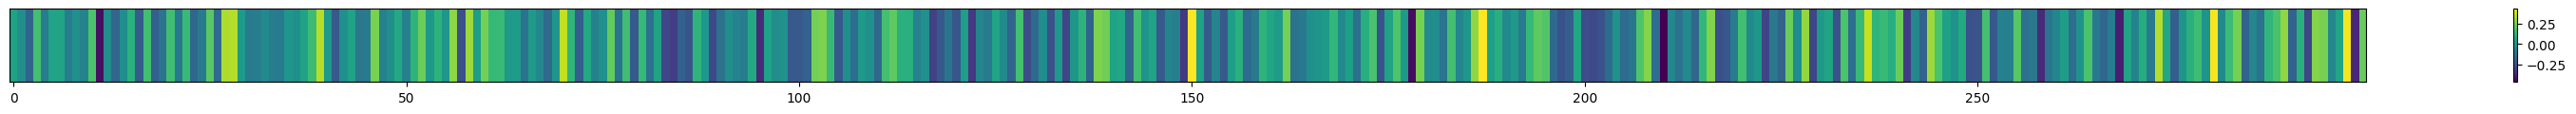

In [8]:
plt.figure(figsize=(40, 1))  # Set the figure size
plt.imshow(dog_vector.reshape((1,300)), aspect='auto', cmap='viridis')  # Display data as an image
plt.colorbar()  # Show the color scale
plt.yticks([])
plt.show()

In [9]:
wv.most_similar('dog', topn=5)

[('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627376914024353),
 ('cat', 0.7609457969665527)]

# Positional Encoding + Word Vectors

In transformer networks, the order of the words which appear in the sentence is captured by enriching the word vectors with positional encodings. Imagine these positional encodings capturing the "time" at which the words appear in the sentence. However, these positional encodings should not be "disruptive" to make the vectors lose their original meaning. Here, I will demonstrate how the positional encodings are implmented based on Attention Is All You Need paper, how it looks like visually and how it looks like to add these positional encodings to the original word vectors. Lastly, I will show what I mean by non-destructive additon of positional information to word vectors by getting the NN of the enriched word vector with positional data. The NNs of this new vector should be similar to the original word vectors NNs.

The devil is in the details. The details of choosing the correct positional encoding, choosing how much you want to attenuate your positional encoding so that it does not push your original word vector too much, and making a good use of high dimensional space. Since we are working with 300 dimensions, we have so much room to enrich the original vectors without disrupting them too much (if we have very low dimensional vectors, we can disrupt them quite easily)

This is what positonal encodings alone would look like. It leverages sinusodial functions to elegantly encode the positional information

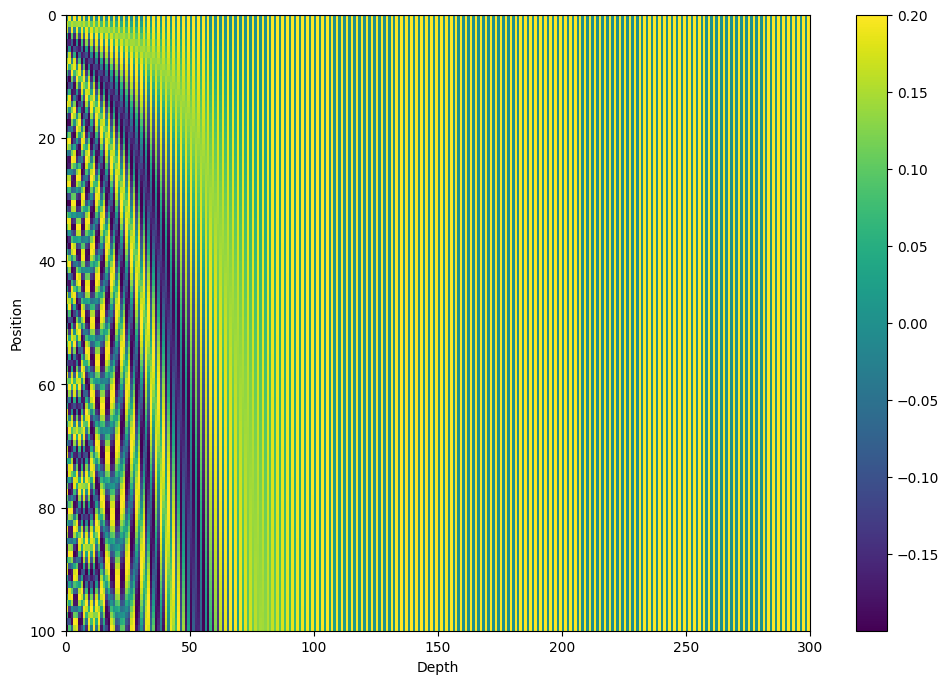

In [10]:
import numpy as np

def get_positional_encodings(max_seq_len, d_model):
    # Initialize a matrix (max_seq_len, d_model) for storing the positional encodings
    positional_encodings = np.zeros((max_seq_len, d_model))

    # Compute the positional encodings
    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            # Apply sine to the even indices in the array
            positional_encodings[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))/5

            if i + 1 < d_model:
                # Apply cosine to the odd indices in the array
                positional_encodings[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))/5

    return positional_encodings

# Set the maximum sequence length and the dimensionality of the embeddings
max_seq_len = 100
d_model = 300

# Compute the positional encodings
positional_encodings = get_positional_encodings(max_seq_len, d_model)

# Visualize the positional encodings
plt.figure(figsize=(12,8))
plt.pcolormesh(positional_encodings, cmap='viridis')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylim((max_seq_len, 0))
plt.ylabel('Position')
plt.colorbar()
plt.show()


y-axis represents the position of the word in the sentence. x-axis represent the dimension of the vector

Now, we will combine the concepts

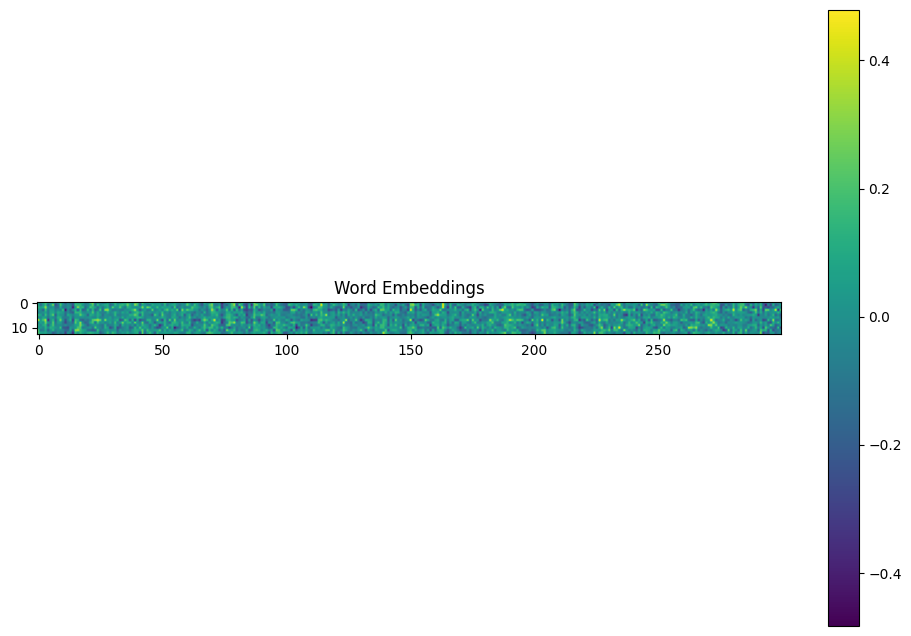

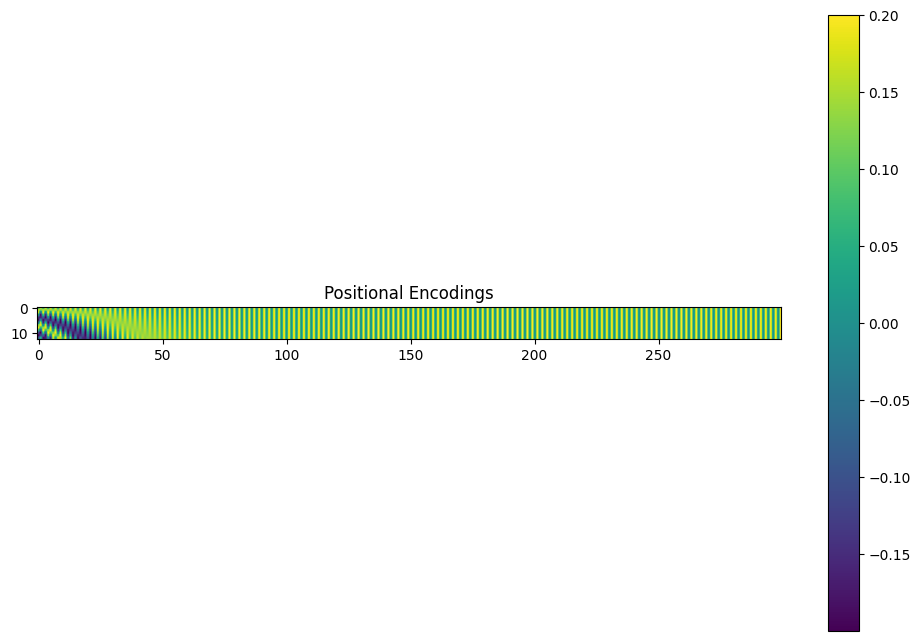

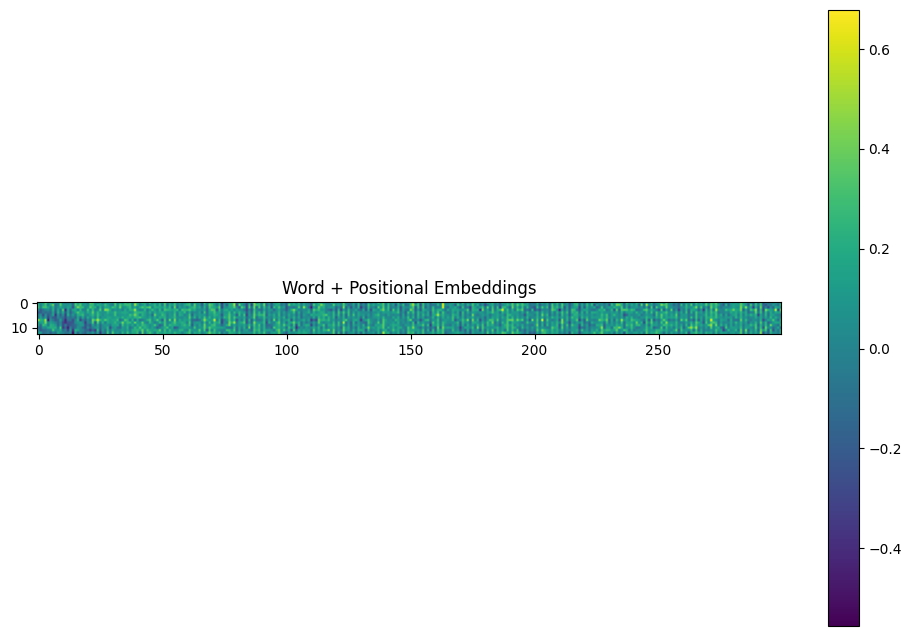

In [11]:
# Define the sentence and get the word embeddings
sentence = "I love my dog so much that I don't think I can live without him"
word_embeddings = {word: wv[word] for word in sentence.split(' ')}

# Get the maximum sequence length and the dimensionality of the embeddings
max_seq_len = len(word_embeddings)
d_model = word_embeddings[list(word_embeddings.keys())[0]].shape[0]  # Assume all word vectors have the same shape

# Compute the positional encodings
positional_encodings = get_positional_encodings(max_seq_len, d_model)

# Add the positional encodings to the word embeddings
word_plus_positional_embeddings = {word: embedding + positional_encodings[i] for i, (word, embedding) in enumerate(word_embeddings.items())}

# Visualize the word embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_embeddings.values())))
plt.title('Word Embeddings')
plt.colorbar()
plt.show()

# Visualize the positional encodings
plt.figure(figsize=(12, 8))
plt.imshow(positional_encodings)
plt.title('Positional Encodings')
plt.colorbar()
plt.show()

# Visualize the combined word plus positional embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_plus_positional_embeddings.values())))
plt.title('Word + Positional Embeddings')
plt.colorbar()
plt.show()


Let's compare the NNs of the original word vector VS the enriched word vector with positional information. There is slight difference, but semantics is not lost completely.

There are a few knobs that you can tune to positional encoding function so that the positional information addition attenuates the original vector less.

However, in the paper, the authors also mention that these positional encodings can be a trainable layer. However, for intuition, I suggest you fixate on this sinusodial function first.

In [12]:
enriched = word_plus_positional_embeddings['dog']
original = dog_vector

In [13]:
wv.similar_by_vector(enriched, topn=5)

[('dog', 0.7655819654464722),
 ('puppy', 0.6642422676086426),
 ('dogs', 0.664111316204071),
 ('golden_retriever', 0.6435234546661377),
 ('Pomeranian', 0.6428695917129517)]

In [14]:
wv.similar_by_vector(original, topn=5)

[('dog', 1.0),
 ('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627376914024353)]

# Aggressive modification to word vectors

Now, we are intentionally making positional encodings to wash away original word vectors. Let's see what are the nearest neighbours of the a new embedding which was added with aggressive positional encoding.

In [15]:
print(sentence)

I love my dog so much that I don't think I can live without him


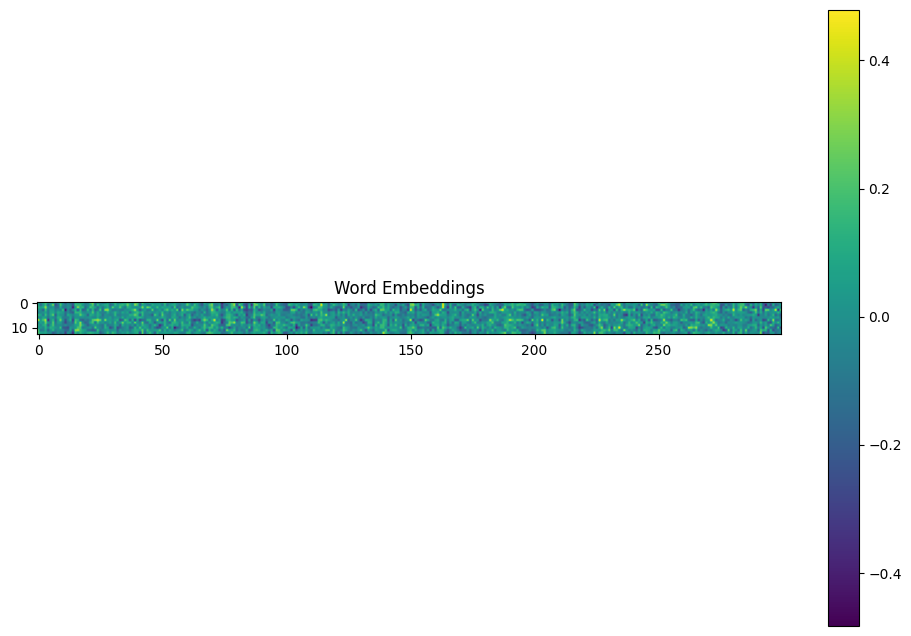

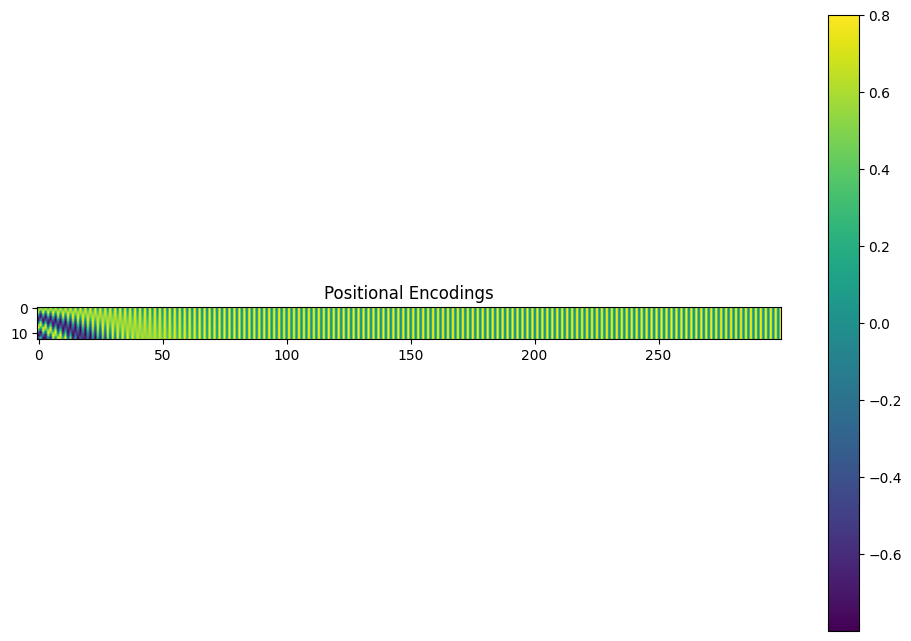

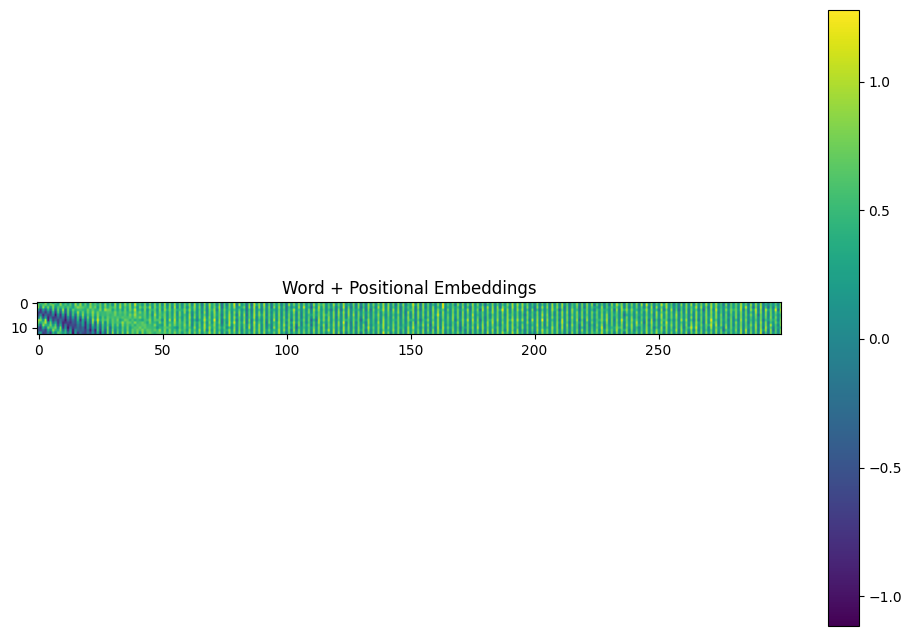

In [16]:
# Amplify positional encodings by 4 times
positional_encodings *= 4

# Add the positional encodings to the word embeddings
word_plus_positional_embeddings = {word: embedding + positional_encodings[i] for i, (word, embedding) in enumerate(word_embeddings.items())}

# Visualize the word embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_embeddings.values())))
plt.title('Word Embeddings')
plt.colorbar()
plt.show()

# Visualize the positional encodings
plt.figure(figsize=(12, 8))
plt.imshow(positional_encodings)
plt.title('Positional Encodings')
plt.colorbar()
plt.show()

# Visualize the combined word plus positional embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_plus_positional_embeddings.values())))
plt.title('Word + Positional Embeddings')
plt.colorbar()
plt.show()

In [17]:
enriched = word_plus_positional_embeddings['dog']
original = dog_vector

In [18]:
wv.similar_by_vector(enriched, topn=5)

[('Pomeranian', 0.3260219395160675),
 ('Shih_Tzu', 0.3202176094055176),
 ('Siamese_cat', 0.31516146659851074),
 ('miniature_dachshund', 0.31130996346473694),
 ('Charles_spaniel', 0.30743056535720825)]

In [19]:
wv.similar_by_vector(original, topn=5)

[('dog', 1.0),
 ('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627376914024353)]

Now you will be seeing that it is moving further away from "dog" but still in the realm of dog breeds so it is still not that bad but if we push even further, we will have more dramatic results

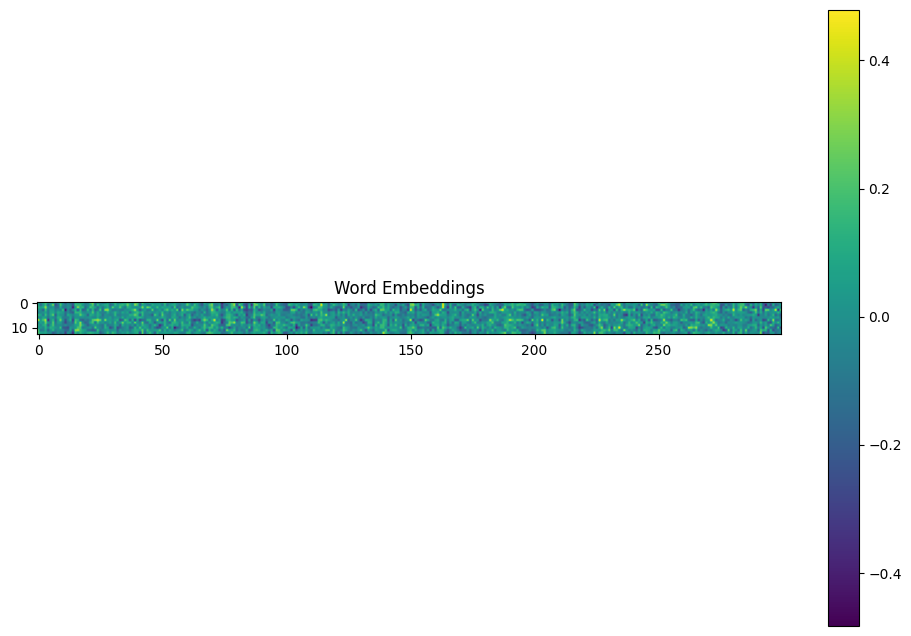

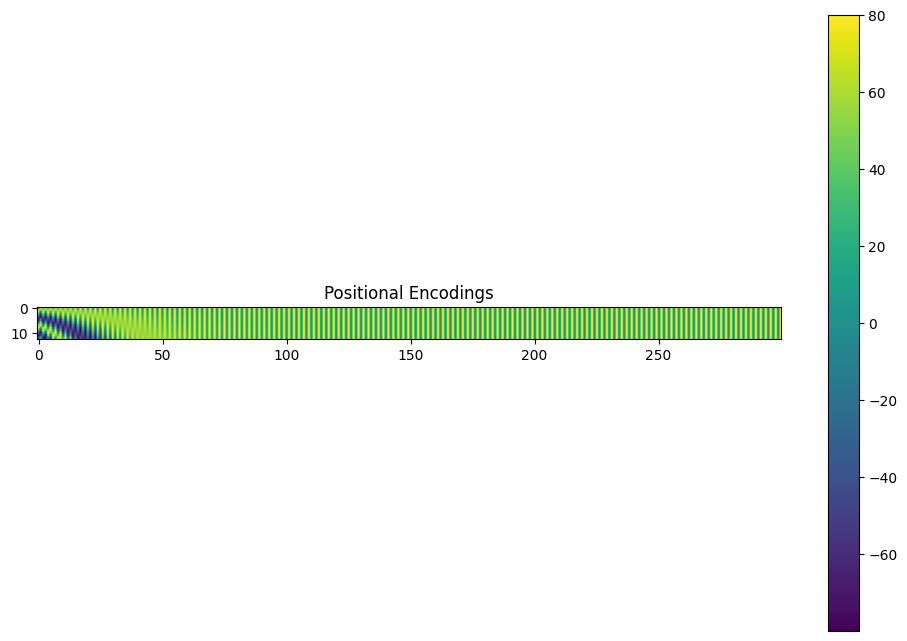

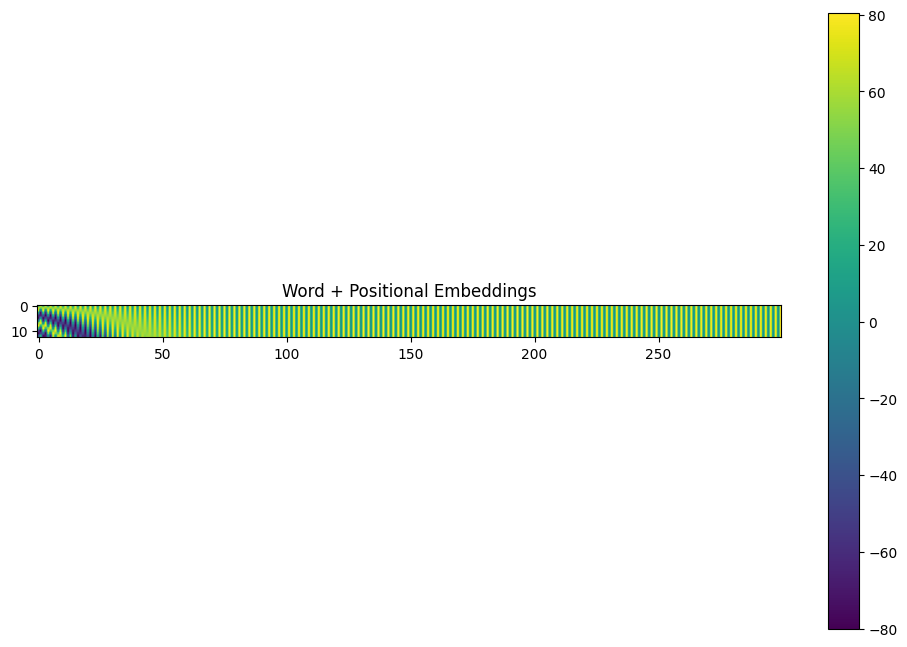

In [21]:
# Amplify positional encodings by 10 times
positional_encodings *= 10

# Add the positional encodings to the word embeddings
word_plus_positional_embeddings = {word: embedding + positional_encodings[i] for i, (word, embedding) in enumerate(word_embeddings.items())}

# Visualize the word embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_embeddings.values())))
plt.title('Word Embeddings')
plt.colorbar()
plt.show()

# Visualize the positional encodings
plt.figure(figsize=(12, 8))
plt.imshow(positional_encodings)
plt.title('Positional Encodings')
plt.colorbar()
plt.show()

# Visualize the combined word plus positional embeddings
plt.figure(figsize=(12, 8))
plt.imshow(np.array(list(word_plus_positional_embeddings.values())))
plt.title('Word + Positional Embeddings')
plt.colorbar()
plt.show()

In [22]:
enriched = word_plus_positional_embeddings['dog']
original = dog_vector

In [23]:
wv.similar_by_vector(enriched, topn=5)

[('incorrigibly', 0.22895491123199463),
 ('greatest_backhanded_compliments', 0.22669385373592377),
 ('classicism', 0.22590094804763794),
 ('Golubeva', 0.223329097032547),
 ('Darya_Zhukova', 0.22296947240829468)]

In [24]:
wv.similar_by_vector(original, topn=5)

[('dog', 1.0),
 ('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627376914024353)]

Now they mean very very different things in the embedding space.

# Why do positional encodings matter

Consider two sentences:
* "My best friend is my dog"
* "My dog is my best friend"

These two sentences are not semantically different. In this case, the addition of positional encodings to individual word vectors does not show the importance of adding positional information to word vectors. For this case, even a simple Bag of Words (BoW) model would suffice to capture the semantics of the input sentence.

BUT, consider these two sentences now:
* "The dog chases the cat"
* "The cat chases the dog"

These are two semantically different sentences. If you are building a text-to-image generation model, the language model has to understand who is chasing and who is running away, so that it could produce an embedding vector appropriate for synthetic image generation model to take as input to generate the image with correct scenario.


Therefore, it is important to encode positional information to input tokens before they are fed to encoder and decoder of transformer networks. Since the input tokens are ingested one-shot (not one at a time like RNNs or LSTMs) and if they are not attached with any positional information, they will end up being treated as a bag of words (since self-attention mechanism does not care about ordering tokens at all)

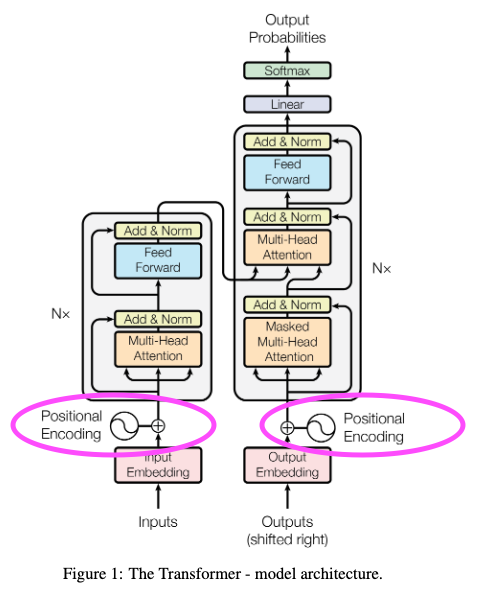

# Are resulting vectors same or different for words at same location in two different sentences?

The short answer is, YES they are the same. If we are just talking about vanilla inputs without considering any sort of training word embeddings, YES they are exactly the same. WHY? If we are talking about word vector lookup from a pre-trained model and we are adding positional encoding to the same vector, it is a simple linear operation and there is no reason for them to be any different. Our sinusodial positional encoding is also not dependent length of the sequence (if you have a short sequence, it is like a cropped version of bigger positional encoding image, rather than a resized one).

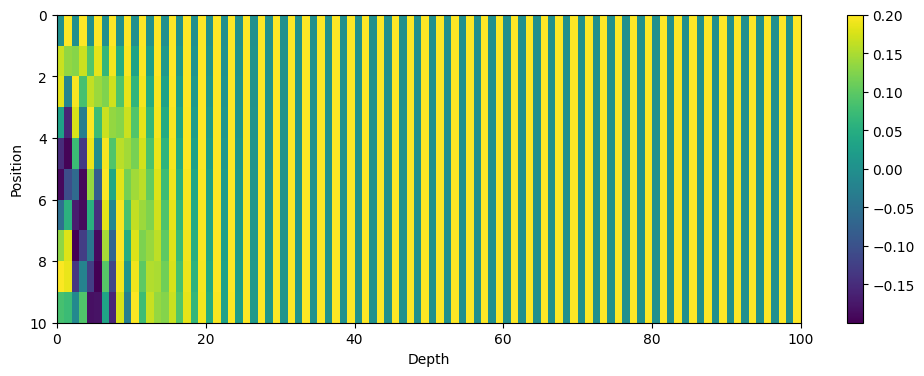

In [64]:
# Compute the positional encodings
d_model = 100
d_sequence = 10
positional_encodings = get_positional_encodings(d_sequence, d_model)

# Visualize the positional encodings
plt.figure(figsize=(12,4))
plt.pcolormesh(positional_encodings, cmap='viridis')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylim((d_sequence, 0))
plt.ylabel('Position')
plt.colorbar()
plt.show()

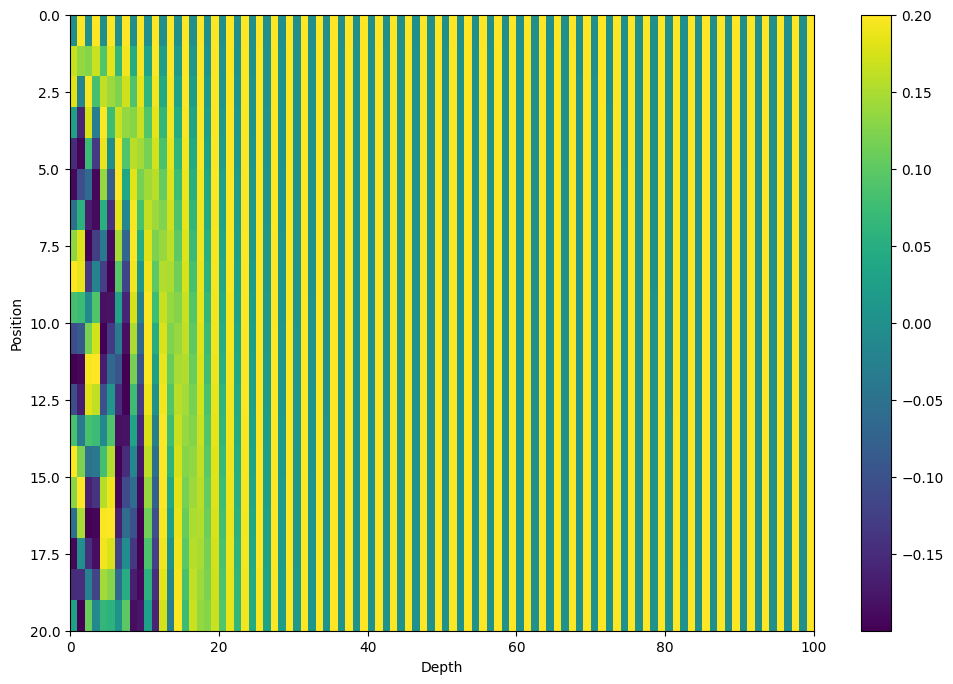

In [65]:

# Compute the positional encodings
d_model = 100
d_sequence = 20
positional_encodings = get_positional_encodings(d_sequence, d_model)

# Visualize the positional encodings
plt.figure(figsize=(12,8))
plt.pcolormesh(positional_encodings, cmap='viridis')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylim((d_sequence, 0))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [48]:
sentence1 = "My dog is my best friend"
sentence2 = "The dog is quite mean"

In [49]:
word_embeddings_1 = {word: wv[word] for word in sentence1.split(' ')}
max_seq_len_1 = len(word_embeddings_1)
d_model_1 = word_embeddings_1[list(word_embeddings_1.keys())[0]].shape[0]
positional_encodings_1 = get_positional_encodings(max_seq_len_1, d_model_1)
word_plus_positional_embeddings_1 = {word: embedding + positional_encodings_1[i] for i, (word, embedding) in enumerate(word_embeddings_1.items())}


word_embeddings_2 = {word: wv[word] for word in sentence2.split(' ')}
max_seq_len_2 = len(word_embeddings_2)
d_model_2 = word_embeddings_2[list(word_embeddings_2.keys())[0]].shape[0]
positional_encodings_2 = get_positional_encodings(max_seq_len_2, d_model_2)
word_plus_positional_embeddings_2 = {word: embedding + positional_encodings_2[i] for i, (word, embedding) in enumerate(word_embeddings_2.items())}


print(np.array_equal(word_plus_positional_embeddings_1["dog"], word_plus_positional_embeddings_2["dog"]))

True


Of course, if the dog appears at a different place, it will not the same anymore since the the word vector at different positions in the sentence will be added with different positional encoding.

In [50]:
sentence3 = "He adopted cute dog"
word_embeddings_3 = {word: wv[word] for word in sentence3.split(' ')}
max_seq_len_3 = len(word_embeddings_3)
d_model_3 = word_embeddings_3[list(word_embeddings_3.keys())[0]].shape[0]
positional_encodings_3 = get_positional_encodings(max_seq_len_3, d_model_3)
word_plus_positional_embeddings_3 = {word: embedding + positional_encodings_3[i] for i, (word, embedding) in enumerate(word_embeddings_3.items())}

print(np.array_equal(word_plus_positional_embeddings_1["dog"], word_plus_positional_embeddings_3["dog"]))

False
